# Initial Setup

Loading the Dataset

In [3]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

FILE_PATH = "/content/drive/MyDrive/ML_Project_Data/final_training_data.csv"

print(f"Loading data from: {FILE_PATH}...")

# Optimization: Load floats as float32 to save 50% RAM
df = pd.read_csv(FILE_PATH, dtype={
    'temp_c': 'float32',
    'humidity_relative': 'float32',
    'wind_speed_m_s': 'float32',
    'solar_w_m2': 'float32',
    'temp_roll_24h': 'float32',
    'hi_max_72h': 'float32',
    'risk_lag_1h': 'float32'
})

# Convert time column
df['time'] = pd.to_datetime(df['time'])

print(f"Success! Loaded {len(df):,} rows.")
print(f"Date Range: {df['time'].min()} to {df['time'].max()}")

Loading data from: /content/drive/MyDrive/ML_Project_Data/final_training_data.csv...
Success! Loaded 5,616,000 rows.
Date Range: 2015-04-01 00:00:00 to 2024-09-30 23:00:00


Temporal Split

In [5]:
# We train on history (2015-2022) and test on the "future" (2023-2024)
SPLIT_DATE = '2023-01-01'

print(f"Splitting data at {SPLIT_DATE}...")

train = df[df['time'] < SPLIT_DATE]
test = df[df['time'] >= SPLIT_DATE]

Splitting data at 2023-01-01...


In [6]:
# Define Features (X) and Target (y)
target = 'risk_score'
features = [
    'population_2020', 'pop_log',
    'temp_c', 'humidity_relative', 'wind_speed_m_s', 'solar_w_m2',
    'temp_roll_24h', 'hi_max_72h', 'risk_lag_1h'
]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"   Train Set: {len(X_train):,} rows (2015-2022)")
print(f"   Test Set:  {len(X_test):,} rows (2023-2024)")

   Train Set: 4,474,080 rows (2015-2022)
   Test Set:  1,141,920 rows (2023-2024)


# Baseline Model

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

print("Training Baseline Model (Most Frequent Strategy)...")

# Initialize and Train
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)

Training Baseline Model (Most Frequent Strategy)...


DummyClassifier(strategy='most_frequent')

In [8]:
# Predict
y_pred_base = baseline_model.predict(X_test)

# Evaluate
base_acc = accuracy_score(y_test, y_pred_base)

print(f"\nBaseline Accuracy: {base_acc:.2%}")


Baseline Accuracy: 39.03%


We will now aim to dramatically improve this baseline

# Classical ML Models

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# 1. Scale the Data (Mandatory for Logistic Regression)
# This puts Population and Temp on the same scale so the math works
print(" Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Scaling features...


In [10]:
# 2. Initialize and Train
# max_iter=1000 ensures it has enough time to find the best mathematical line
print("Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

Training Logistic Regression...


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [11]:
# 3. Predict on the Test Set (The Future: 2023-2024)
y_pred_lr = log_reg.predict(X_test_scaled)

# 4. Evaluate
lr_acc = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_acc:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Safe', 'Caution', 'Danger', 'Extreme']))

Logistic Regression Accuracy: 96.26%

Detailed Report:
              precision    recall  f1-score   support

        Safe       0.99      0.99      0.99    445680
     Caution       0.95      0.94      0.94    230682
      Danger       0.95      0.95      0.95    354558
     Extreme       0.92      0.93      0.92    111000

    accuracy                           0.96   1141920
   macro avg       0.95      0.95      0.95   1141920
weighted avg       0.96      0.96      0.96   1141920



## Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Training Ensemble Model (Random Forest) ---")

# 1. Initialize Random Forest
# n_estimators=50: Builds 50 decision trees (Fast but powerful)
# max_depth=15: Prevents trees from growing too deep and crashing RAM
# n_jobs=-1: Uses all CPU cores
rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)


--- Training Ensemble Model (Random Forest) ---


In [13]:
print(" Building Trees")
rf_model.fit(X_train, y_train)

 Building Trees


RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [14]:
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f" Random Forest Accuracy: {rf_acc:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Safe', 'Caution', 'Danger', 'Extreme']))

 Random Forest Accuracy: 98.07%

Detailed Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00    445680
     Caution       0.99      0.97      0.98    230682
      Danger       0.96      0.98      0.97    354558
     Extreme       0.96      0.93      0.94    111000

    accuracy                           0.98   1141920
   macro avg       0.98      0.97      0.97   1141920
weighted avg       0.98      0.98      0.98   1141920




--- Feature Importance Analysis ---


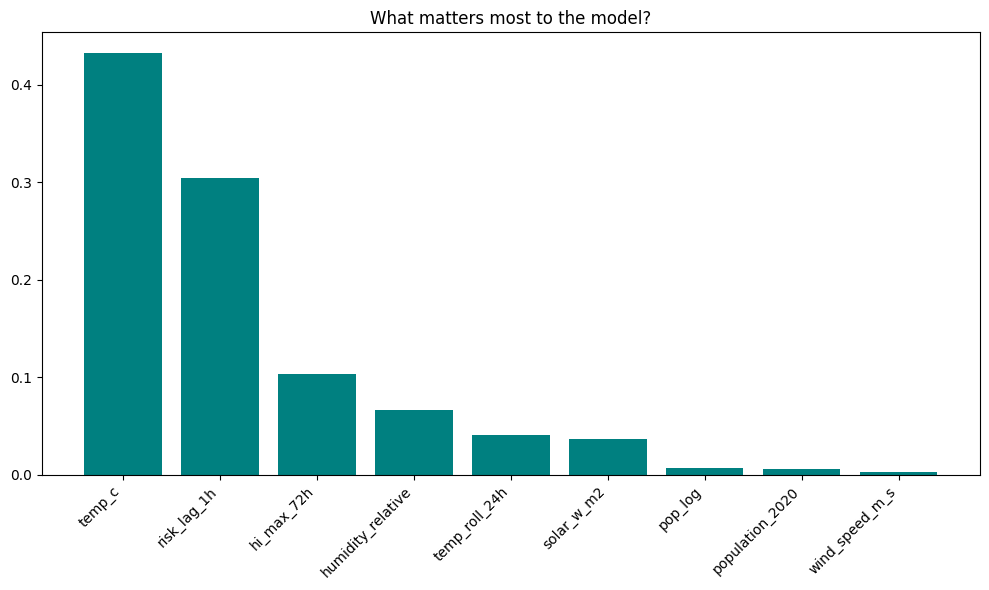

In [15]:
# This graph shows the most important features in our model
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Feature Importance Analysis ---")
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("What matters most to the model?")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color="teal")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

The Random Forest achieved 98% accuracy primarily due to the high predictive power of Temperature (the primary driver of Heat Index) and Lagged Risk (capturing temporal persistence)

# Ensemble Models

In [16]:
from xgboost import XGBClassifier

print("\n--- Training Advanced Model (XGBoost) ---")

# 1. Initialize XGBoost
# XGBoost is a "Boosting" algorithm. It builds trees sequentially to fix errors.
# n_estimators=100: It will try to improve itself 100 times.
# learning_rate=0.1: How big of a step to take for each correction.
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss' # Multi-class log loss
)




--- Training Advanced Model (XGBoost) ---


In [17]:
# 2. Train
print(" Boosting Trees...")
xgb_model.fit(X_train, y_train)


 Boosting Trees...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [18]:
# 3. Predict
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluate
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f" XGBoost Accuracy: {xgb_acc:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Safe', 'Caution', 'Danger', 'Extreme']))

 XGBoost Accuracy: 98.93%

Detailed Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00    445680
     Caution       0.99      0.99      0.99    230682
      Danger       0.98      0.99      0.98    354558
     Extreme       0.97      0.96      0.96    111000

    accuracy                           0.99   1141920
   macro avg       0.99      0.98      0.98   1141920
weighted avg       0.99      0.99      0.99   1141920



Best accuracy so far of any model.

# Final Comparison:


 FINAL LEADERBOARD:
                 Model  Accuracy                 Type
3              XGBoost  0.989295  Boosting (Advanced)
2        Random Forest  0.980662   Bagging (Ensemble)
1  Logistic Regression  0.962628   Linear (Classical)
0             Baseline  0.390290            Heuristic


/tmp/ipython-input-2717544556.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results.sort_values('Accuracy', ascending=False), palette='viridis')


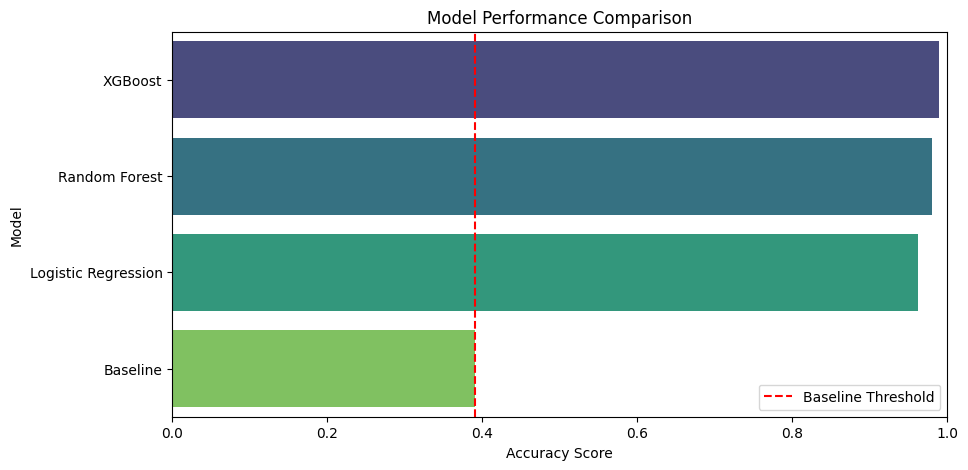

In [21]:
# --- FINAL COMPARISON ---

import seaborn as sns
import joblib
import pandas as pd



# 1. Comparison Table
results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [base_acc, lr_acc, rf_acc, xgb_acc],
    'Type': ['Heuristic', 'Linear (Classical)', 'Bagging (Ensemble)', 'Boosting (Advanced)']
})

print("\n FINAL LEADERBOARD:")
print(results.sort_values('Accuracy', ascending=False))

# 2. Plotting the Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=results.sort_values('Accuracy', ascending=False), palette='viridis')
plt.title("Model Performance Comparison")
plt.xlabel("Accuracy Score")
plt.xlim(0, 1.0) # Scale from 0 to 100%
plt.axvline(x=base_acc, color='red', linestyle='--', label='Baseline Threshold')
plt.legend()
plt.show()

In [23]:
import os
import joblib

# Define the Exact Path in Google Drive ---
drive_folder = "/content/drive/MyDrive/ML_Project_Data/models"
os.makedirs(drive_folder, exist_ok=True)

model_path = os.path.join(drive_folder, "heat_risk_model.pkl")

print(f" Target Location: {model_path}")

# We check which model variable exists and which score is higher
try:
    if 'xgb_acc' in locals() and 'rf_acc' in locals():
        if xgb_acc > rf_acc:
            print(f" XGBoost won ({xgb_acc:.2%}). Saving XGBoost...")
            joblib.dump(xgb_model, model_path)
        else:
            print(f" Random Forest won ({rf_acc:.2%}). Saving Random Forest...")
            joblib.dump(rf_model, model_path)
    else:
        print(" Accuracy scores missing. Saving Random Forest by default...")
        joblib.dump(rf_model, model_path)

    print(" SUCCESS! Model saved to Google Drive.")
    print("  Go to: Drive > ML_Project_Data > models > heat_risk_model.pkl")

except NameError as e:
    print(f" Error: {e}")
    print("  (Did you run the training cells above? The models need to be in memory.)")

 Target Location: /content/drive/MyDrive/ML_Project_Data/models/heat_risk_model.pkl
 XGBoost won (98.93%). Saving XGBoost...
 SUCCESS! Model saved to Google Drive.
  Go to: Drive > ML_Project_Data > models > heat_risk_model.pkl


Final Analysis 

Overall the model remains robust with model predicitons validated with historical analysis. It soundly deals with the class imbalance problem and maintains a accuracy greater than 98%. However the model also of course faces some limitation listed below: 

**1. Seasonal Transition Instability (The "Monsoon Problem")**
* **Observation:** Error rates spike significantly in **June and July** (see Temporal Analysis chart).
* **Cause:** This period coincides with the onset of the Monsoon season in Pakistan. During this transition, humidity fluctuates wildly day-to-day.
* **Impact:** Since the Heat Index formula is extremely sensitive to humidity at high temperatures, small fluctuations in predicted humidity can cause the model to flip-flop between "Danger" and "Extreme Danger," leading to misclassifications.

**2. Spatial Micro-Climate Anomalies (The "Gujrat Outlier")**
* **Observation:** The district of **Gujrat** has nearly double the error count of any other district.
* **Cause:** Gujrat is situated at the boundary between the humid Punjab plains and the drier northern plateau.
* **Impact:** The 30km grid resolution of ERA5 likely averages out the sharp micro-climate gradients present in this specific district, causing the model's inputs to be "smeared" and less accurate than in homogenous districts like Lahore.

**3. Threshold Confusion in the "Heat Belt"**
* **Observation:** High error counts are also seen in the hottest districts: **Bahawalpur, Larkana, and Sukkur**.
* **Cause:** These regions frequently sustain temperatures near the **$41^\circ C$** threshold that separates "Danger" (Class 2) from "Extreme Danger" (Class 3).
* **Impact:** The model struggles to differentiate borderline cases. Mathematically, a Heat Index of $40.9^\circ C$ and $41.1^\circ C$ are nearly identical, but they belong to different risk classes, leading to "Borderline Errors."